In [1]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import torch.nn as nn
import numpy as np

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
import seaborn as sns
from scipy import ndimage

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [2]:
def mse_b_unique(a, b):
    return nn.MSELoss()(a[:, [0, 1, 2, 4, 5, 8]], b[:, [0, 1, 2, 4, 5, 8]])

In [3]:
# set path to models and initialize arrays
model_base = '../../storage/models/kaandorp_data/ph_cdc_sd/'
add_feat_path = 'additional_features/phill_2800_10595_cdc_12600_sd_2000_2400_2900_3200_reg_1e-10_lr_10e-07_lr_scheduler_2/'
original_feat_path = 'original_features/phill_2800_10595_cdc_12600_sd_2000_2400_2900_3200_reg_1e-10_lr_10e-07_lr_scheduler_2/'

# load in model from additional features
model_add = th.load(os.sep.join([model_base, add_feat_path, 'model.pt']))
mu_add = th.load(os.sep.join([model_base, add_feat_path, 'mu.th']))
std_add = th.load(os.sep.join([model_base, add_feat_path, 'std.th']))
_ = model_add.eval()

# load in model from original features
model_orig = th.load(os.sep.join([model_base, original_feat_path, 'model.pt']))
mu_orig = th.load(os.sep.join([model_base, original_feat_path, 'mu.th']))
std_orig = th.load(os.sep.join([model_base, original_feat_path, 'std.th']))
_ = model_orig.eval()

In [5]:
# read in tensor data
rans_path = '/home/leonriccius/Desktop/SquareDuct/Re3500_kOmega_50_ml/'

rans_time = max([int(entry) for entry in os.listdir(rans_path) if entry.isnumeric()])
rans_time = '50000'

with NoStdStreams():
    u = pre.readVectorData(rans_time, 'U', rans_path)
    grid = pre.readCellCenters(rans_time, rans_path)
    rs = pre.readSymTensorData(rans_time, 'turbulenceProperties:R', rans_path).reshape(-1, 3, 3)
    grad_u = pre.readTensorData(rans_time, 'grad(U)', rans_path)
    grad_k = pre.readVectorData(rans_time, 'grad(k)', rans_path)
    grad_p = pre.readVectorData(rans_time, 'grad(p)', rans_path)
    y_wall = pre.readScalarData(rans_time, 'wallDistance', rans_path)
    k = pre.readScalarData(rans_time, 'k', rans_path)
    omega = pre.readScalarData(rans_time, 'omega', rans_path)  # 'epsilon' or 'omega'
    epsilon = omega * k * 0.09  # 0.09 is beta star
    nu = 0.00013770285714285714

# get b_rans
b_rans = barymap.anisotropy(rs, k)

# calculate mean rate of strain and rotation tensors
s = 0.5 * (grad_u + grad_u.transpose(1, 2))
r = 0.5 * (grad_u - grad_u.transpose(1, 2))

# normalize s and r
s_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * s
r_hat = (k / epsilon).unsqueeze(1).unsqueeze(2) * r
grad_k_hat = (th.sqrt(k) / epsilon).unsqueeze(1) * grad_k

# capping tensors
s_hat = cap_tensor(s_hat, 6.0)
r_hat = cap_tensor(r_hat, 6.0)

# get invariants and remove features
inv_fs1 = get_invariants(s_hat, r_hat)
for i in [3,4][::-1]:  # must be in reverse or indices are wrong
    inv_fs1 = th.cat((inv_fs1[:, :i - 1], inv_fs1[:, i:]), dim=1)

inv_fs2 = get_invariants_fs2(s_hat, r_hat, grad_k_hat)
for i in [4, 5, 6, 7, 8, 10, 11, 12][::-1]:  # must be in reverse or indices are wrong
    inv_fs2 = th.cat((inv_fs2[:, :i - 1], inv_fs2[:, i:]), dim=1)

inv_fs3 = get_invariants_fs3(s, r, rs, u, grad_u, grad_p, grad_k, k, epsilon, y_wall, nu)

inv_add = th.cat((inv_fs1, inv_fs2, inv_fs3), dim=1)

# scale invariants
inv_mean_std_add = mean_std_scaling(inv_add, mu=mu_add, std=std_add)[0]
inv_mean_std_orig = mean_std_scaling(inv_fs1, mu=mu_orig, std=std_orig)[0]

# get tensor basis
t = get_tensor_functions(s_hat, r_hat)
t_zero_trace = enforce_zero_trace(t.reshape(-1,10,3,3))

# get predictions
b_pred_add,_ = model_add(inv_mean_std_add, t_zero_trace.reshape(-1,10,9))
b_pred_add = b_pred_add.reshape(-1,3,3).detach()
b_pred_orig,_ = model_orig(inv_mean_std_orig, t_zero_trace.reshape(-1,10,9))
b_pred_orig = b_pred_orig.reshape(-1,3,3).detach()

# dns data
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_fs1_fs2_fs3_reduced/SquareDuct/3500'
b_dns = th.load(os.sep.join([path_dns, 'b_dns-torch.th']))
grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))

enforcing 0 trace ...


In [6]:
# enforce realizability on b
b_real_add = b_pred_add.clone()
b_real_orig = b_pred_orig.clone()

for i in range(5):
    with NoStdStreams():
        b_real_add = enforce_realizability(b_real_add)
        b_real_orig = enforce_realizability(b_real_orig)

In [7]:
print('Original Featues')
print('max b:       {:.4f}'.format(th.max(b_pred_orig[:,0,0])))
print('max b_real:  {:.4f}'.format(th.max(b_real_orig[:,0,0])))

print('Additional Featues')
print('max b:       {:.4f}'.format(th.max(b_pred_add[:,0,0])))
print('max b_real:  {:.4f}'.format(th.max(b_real_add[:,0,0])))

Original Featues
max b:       0.4877
max b_real:  0.4877
Additional Featues
max b:       0.5940
max b_real:  0.5936


In [8]:
# filter b_pred
nx, ny = 50, 50
b_real_orig_reshaped = b_real_orig.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_orig_filt = th.from_numpy(filterField(b_real_orig_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)

b_real_add_reshaped = b_real_add.reshape(ny,nx,3,3).permute(2,3,0,1).detach().numpy()
b_real_add_filt = th.from_numpy(filterField(b_real_add_reshaped, std=2)).reshape(3,3,-1).permute(2,0,1)

In [92]:
# boundary list from curved backward facing step
b_list = [('side_walls', 'fixedValue_uniform'),
          ('inlet', 'cyclic'),
          ('outlet', 'cyclic'),
          ('side_left', 'symmetryPlane'),
          ('side_bottom', 'symmetryPlane')]

rans_time = '50000'
dd_case_path = rans_path
# writesymmtensor(b_real_add_filt, os.sep.join([dd_case_path, rans_time, 'b_ml']), b_list)

### Visualize Predicitons
**Contour Plots**

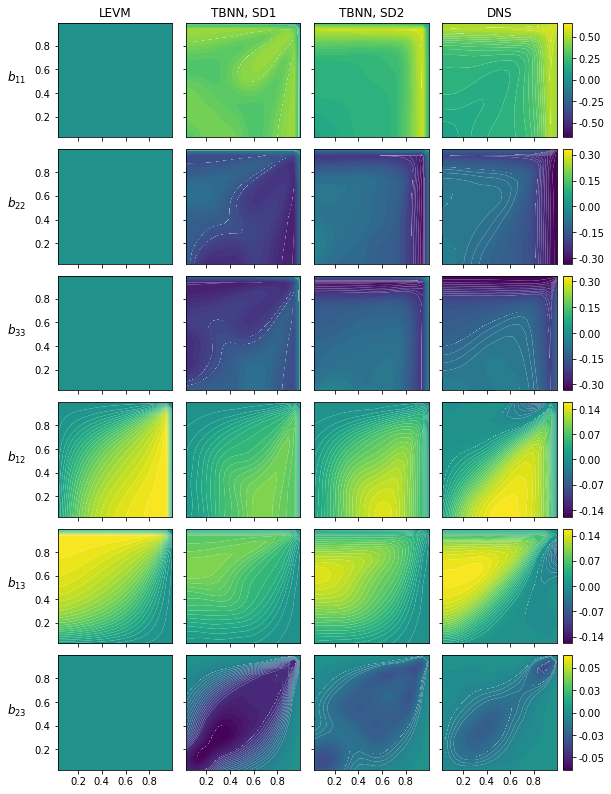

In [9]:
# define refinement level of interpolation grid and how much of boundary should be but off
ref = 20
gamma = 0.995

# find min an max of x coordinate
x_min, x_max = np.min(grid[:,1].numpy()), np.max(grid[:,1].numpy())
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)

# find min an max of y coordinate
y_min, y_max = np.min(grid[:,2].numpy()), np.max(grid[:,2].numpy())
y_mean = 0.5*(y_max - y_min)
y_min = y_mean - gamma*(y_mean - y_min)
y_max = y_mean - gamma*(y_mean - y_max)

# compute number of points per coordinate
np_x = int(ref*(x_max - x_min))
np_y = int(ref*(y_max - y_min))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, np_x), np.linspace(y_min, y_max, np_y))

# interpolate b tensor
grid_b_rans = griddata(grid[:,1:3], b_rans.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real_orig_filt = griddata(grid[:,1:3], b_real_orig_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_real_add_filt = griddata(grid[:,1:3], b_real_add_filt.numpy(), (grid_x, grid_y), method = 'linear')
grid_b_dns = griddata(grid[:,1:3], b_dns.numpy(), (grid_x, grid_y), method = 'linear')

# get min an max of (b_pred, b_test) for colormap
tmp = np.vstack((grid_b_rans, grid_b_real_orig_filt, grid_b_real_add_filt, grid_b_dns))
b_max = np.max(np.abs(tmp), axis=(0,1))
b_min = -np.max(np.abs(tmp), axis=(0,1))

# set components to plot
components = [[0,0], [1,1], [2,2], [0,1], [0,2], [1,2]]

# set ticks for the colorbars
ticks = [np.linspace(-0.5,0.5,5),
         np.linspace(-0.3,0.3,5),
         np.linspace(-0.3,0.3,5),
         np.linspace(-0.14,0.14,5),
         np.linspace(-0.14,0.14,5),
         np.linspace(-0.05,0.05,5)
        ]

# set number of subplots and scale of figure
ncols = 4
nrows = len(components)
s = 0.7

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*3.*ncols, s*2.6*nrows),
                       sharex=True, sharey=True,
                       subplot_kw=dict(aspect='equal'),
                       constrained_layout=True)

for i, cmp in enumerate(components):
    
    # set contour levels
    levels = np.linspace(b_min[cmp[0], cmp[1]], b_max[cmp[0], cmp[1]], 50)

    # plot contours
    b_rans_plot = ax[i,0].contourf(grid_x, grid_y, grid_b_rans[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_orig_plot = ax[i,1].contourf(grid_x, grid_y, grid_b_real_orig_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_pred_add_plot = ax[i,2].contourf(grid_x, grid_y, grid_b_real_add_filt[:,:,cmp[0],cmp[1]], levels = levels)
    b_dns_plot = ax[i,3].contourf(grid_x, grid_y, grid_b_dns[:,:,cmp[0],cmp[1]], levels = levels)
    
    # remove contour lines
    for contour in [b_rans_plot, b_pred_orig_plot, b_pred_add_plot, b_dns_plot]:
        for c in contour.collections:
            c.set_edgecolor("face")
            c.set_linewidth(0.00000000000000001)
    
    # plot colorbar
    cbar = fig.colorbar(b_dns_plot, ax=ax[i,:].flat, aspect=2.5*ncols, format='%.2f', pad=0.0, ticks=ticks[i])

# set component labels
x_off = -0.4
y_off = 0.5
ax[0,0].text(x_off,y_off, r'$b_{11}$', fontsize='large', ha='left')
ax[1,0].text(x_off,y_off, r'$b_{22}$', fontsize='large', ha='left')
ax[2,0].text(x_off,y_off, r'$b_{33}$', fontsize='large', ha='left')
ax[3,0].text(x_off,y_off, r'$b_{12}$', fontsize='large', ha='left')
ax[4,0].text(x_off,y_off, r'$b_{13}$', fontsize='large', ha='left')
ax[5,0].text(x_off,y_off, r'$b_{23}$', fontsize='large', ha='left')

# set titles
ax[0,0].set_title(r'LEVM', fontsize='large')
ax[0,1].set_title(r'TBNN, SD1', fontsize='large')
ax[0,2].set_title(r'TBNN, SD2', fontsize='large')
ax[0,3].set_title(r'DNS', fontsize='large')

# set ticks at far left and bottom figures
for i in range(4):
    ax[5,i].set_xticks([.2, .4, .6, .8])

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/prediction_b/square_duct/'
fig_name =  'prediction_sd1_sd2.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

**Barycentric map colors**

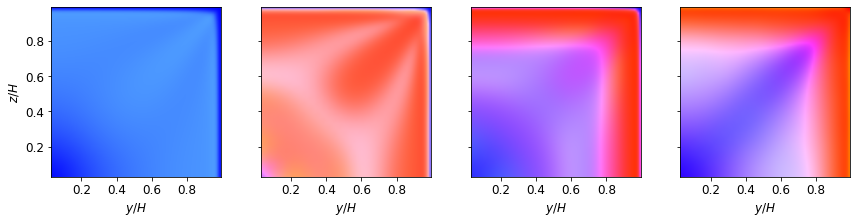

In [10]:
# create barycentric maps
barm_rans = BarMap()
barm_rans.load_from_variable(b_rans, grid[:,1:3])
barm_rans.calculate_barycentric_coordinates()

barm_add = BarMap()
barm_add.load_from_variable(b_real_add_filt, grid[:,1:3])
barm_add.calculate_barycentric_coordinates()

barm_orig = BarMap()
barm_orig.load_from_variable(b_real_orig_filt, grid[:,1:3])
barm_orig.calculate_barycentric_coordinates()

barm_dns = BarMap()
barm_dns.load_from_variable(b_dns, grid[:,1:3])
barm_dns.calculate_barycentric_coordinates()

# get extent of flow case
gamma = 0.995
x_min, x_max = th.min(grid, axis=0)[0][[1,2]], th.max(grid, axis=0)[0][[1,2]]
x_mean = 0.5*(x_max - x_min)
x_min = x_mean - gamma*(x_mean - x_min)
x_max = x_mean - gamma*(x_mean - x_max)
x_max[1] = x_max[1] #-0.001
extent=th.cat([x_min.unsqueeze(0), x_max.unsqueeze(0)]).T.flatten()

# plot flow case
fig, ax = plt.subplots(1,4, figsize = (12,3), sharey=True, sharex=True, constrained_layout=True)
barm_rans.plot_on_geometry(axis=ax[0], flowcase='CBFS', resolution=0.01, extent=extent)
barm_orig.plot_on_geometry(axis=ax[1], flowcase='CBFS', resolution=0.01, extent=extent)
barm_add.plot_on_geometry(axis=ax[2], flowcase='CBFS', resolution=0.01, extent=extent)
barm_dns.plot_on_geometry(axis=ax[3], flowcase='CBFS', resolution=0.01, extent=extent)

# set y ticks
ax[0].tick_params(axis='both', which='major', labelsize='large')
ax[1].tick_params(axis='both', which='major', labelsize='large')
ax[2].tick_params(axis='both', which='major', labelsize='large')
ax[3].tick_params(axis='both', which='major', labelsize='large')

# set x labels
ax[0].set_xlabel(r'$y/H$', fontsize='large')
ax[1].set_xlabel(r'$y/H$', fontsize='large')
ax[2].set_xlabel(r'$y/H$', fontsize='large')
ax[3].set_xlabel(r'$y/H$', fontsize='large')
ax[0].set_ylabel(r'$z/H$', fontsize='large')

for i in range(4):
    ax[i].set_xticks([.2, .4, .6, .8])

# render figure
fig.canvas.draw()

# save figure
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/prediction_b/square_duct/'
fig_name =  'rgb_map.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

**Barycentric traingles**

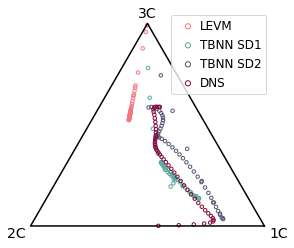

In [12]:
# define colors
# colors=sns.color_palette()
colors = ['#F57680', '#5AABA3', '#565876', '#850C3E']

# find y location
val = 0.25
grid_reshaped = grid.reshape(50,50,3)
y_loc = np.argmin(np.absolute(grid_reshaped[0,:,1] - val))
y_val = grid_reshaped[0, y_loc,1]

# create mask and select points in the slice
grid_slice = grid_reshaped[:, y_loc]
b_rans_slice = b_rans.reshape(50,50,3,3)[:, y_loc]
b_add_slice = b_real_add_filt.reshape(50,50,3,3)[:, y_loc]
b_orig_slice = b_real_orig_filt.reshape(50,50,3,3)[:, y_loc]
b_dns_slice = b_dns.reshape(50,50,3,3)[:, y_loc]

barm_rans_slice = BarMap()
barm_rans_slice.load_from_variable(b_rans_slice, grid[:,1:3])
barm_rans_slice.calculate_barycentric_coordinates()

barm_add_slice = BarMap()
barm_add_slice.load_from_variable(b_add_slice, grid[:,1:3])
barm_add_slice.calculate_barycentric_coordinates()

barm_orig_slice = BarMap()
barm_orig_slice.load_from_variable(b_orig_slice, grid[:,1:3])
barm_orig_slice.calculate_barycentric_coordinates()

barm_dns_slice = BarMap()
barm_dns_slice.load_from_variable(b_dns_slice, grid[:,1:3])
barm_dns_slice.calculate_barycentric_coordinates()

# create figure
fig, ax = plt.subplots(figsize=(4, 3.5), constrained_layout=True)
ax.axis('equal')
ax.axis('off')

# scatter plots
barm_rans_slice.plot_data_points(axis=ax, marker='o', s=12, color=colors[0], facecolors='none') #, linewidth=1., fillstyle='none')
barm_orig_slice.plot_data_points(axis=ax, marker='o', s=12, color=colors[1], facecolors='none') #, linewidth=1., fillstyle='none')
barm_add_slice.plot_data_points(axis=ax, marker='o', s=12, color=colors[2], facecolors='none') #, linewidth=1., fillstyle='none')
barm_dns_slice.plot_data_points(axis=ax, marker='o', s=12, color=colors[3], facecolors='none') #, linewidth=1., fillstyle='none')

# get legend and vertex labels
ax.legend([r'LEVM', r'TBNN SD1', r'TBNN SD2', r'DNS'], markerscale=1.5, fontsize='large', handletextpad=0.0)
barm_rans_slice.plot_triangle(axis=ax)

# add limiting state labels
ax.text(1.1, -0.0, '1C', fontsize=14,
        horizontalalignment='right', verticalalignment='top')
ax.text(-0.1, -0.0, '2C', fontsize=14,
        horizontalalignment='left', verticalalignment='top')
ax.text(0.50, 0.88, '3C', fontsize=14,
        horizontalalignment='center', verticalalignment='bottom')

# save figure
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/prediction_b/square_duct/'
fig_name =  'barycentric_map_075.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

**Compute RMSE**

In [8]:
# mean square error for rans, sd1, sd2
print(mse_b_unique(b_rans.flatten(1), b_dns.flatten(1)))
print(mse_b_unique(b_real_orig_filt.flatten(1), b_dns.flatten(1)))
print(mse_b_unique(b_real_add_filt.flatten(1), b_dns.flatten(1)))
print(th.sqrt(mse_b_unique(b_rans.flatten(1), b_dns.flatten(1))))
print(th.sqrt(mse_b_unique(b_real_orig_filt.flatten(1), b_dns.flatten(1))))
print(th.sqrt(mse_b_unique(b_real_add_filt.flatten(1), b_dns.flatten(1))))

tensor(0.0473, dtype=torch.float64)
tensor(0.0098, dtype=torch.float64)
tensor(0.0044, dtype=torch.float64)
tensor(0.2175, dtype=torch.float64)
tensor(0.0992, dtype=torch.float64)
tensor(0.0663, dtype=torch.float64)
